In [14]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import src
from src.paleoseismic import PaleoseismicCatalog
import os
from pathlib import Path
import yaml

base_dir = Path(src.__file__).parents[1]
data_directory = base_dir/"data"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


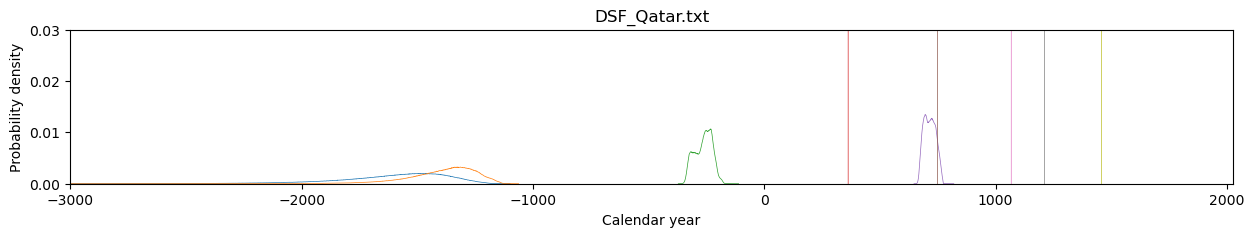

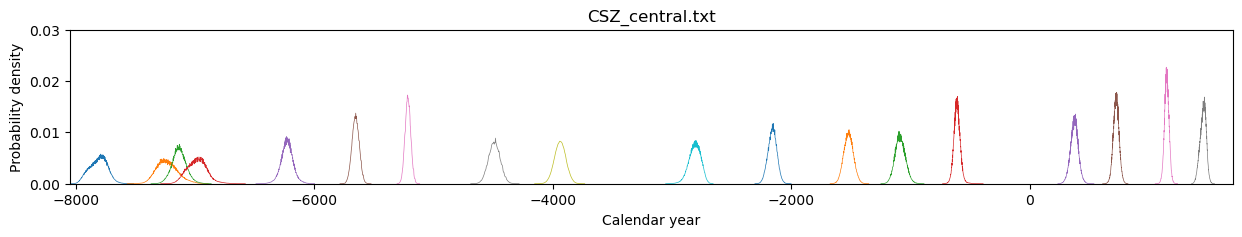

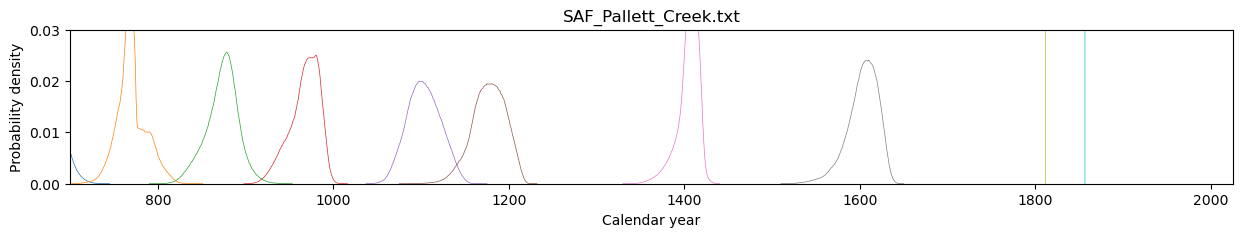

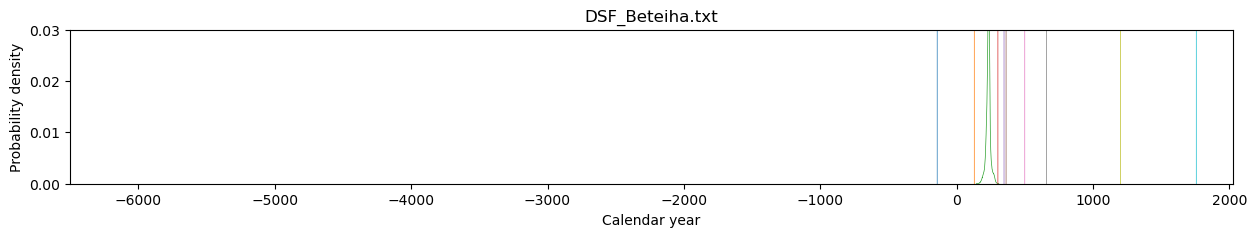

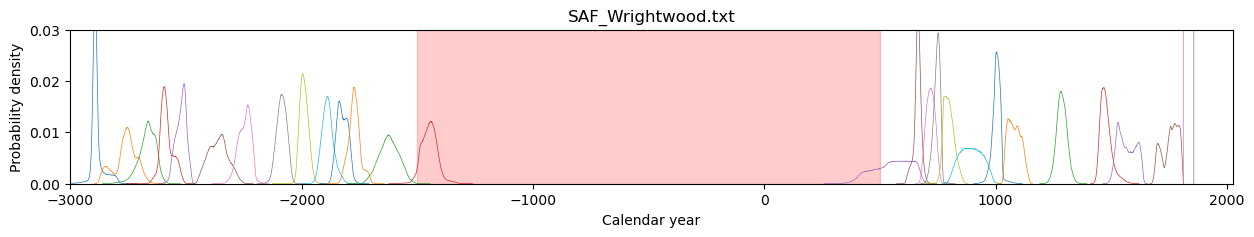

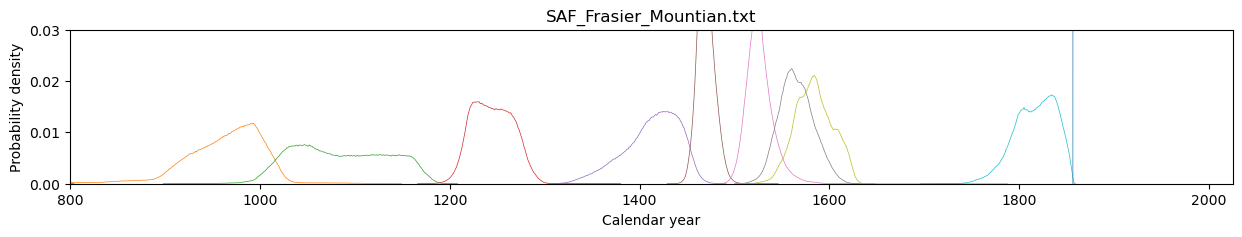

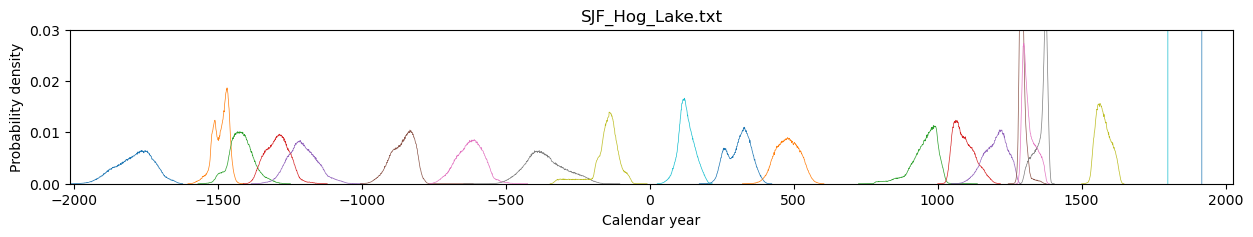

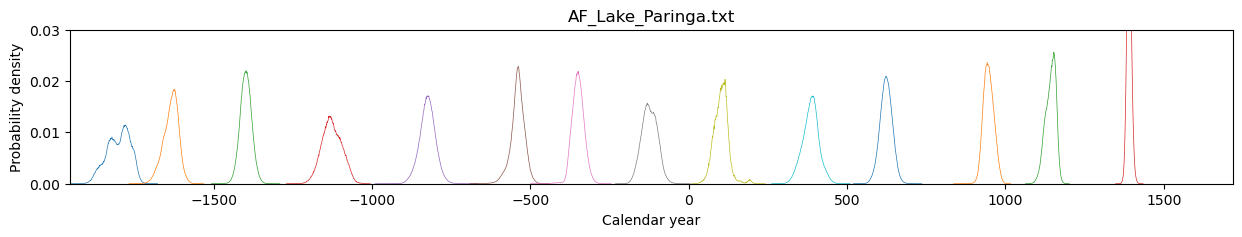

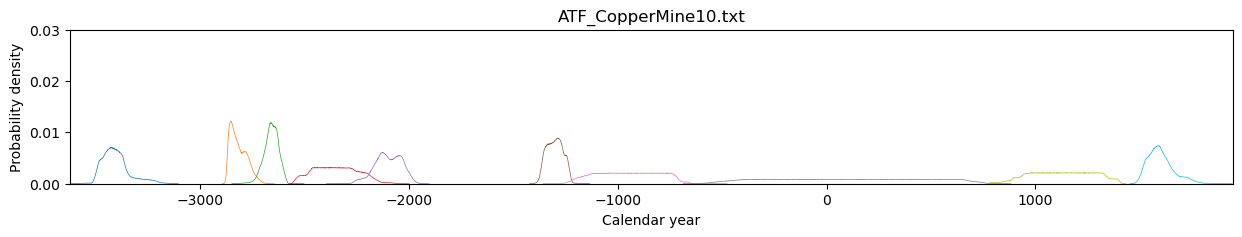

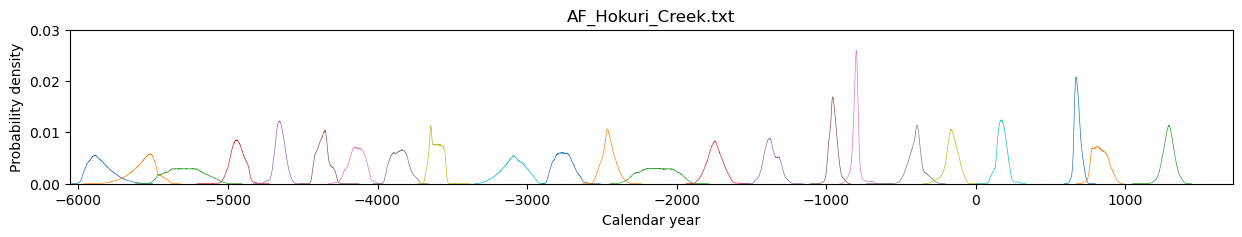

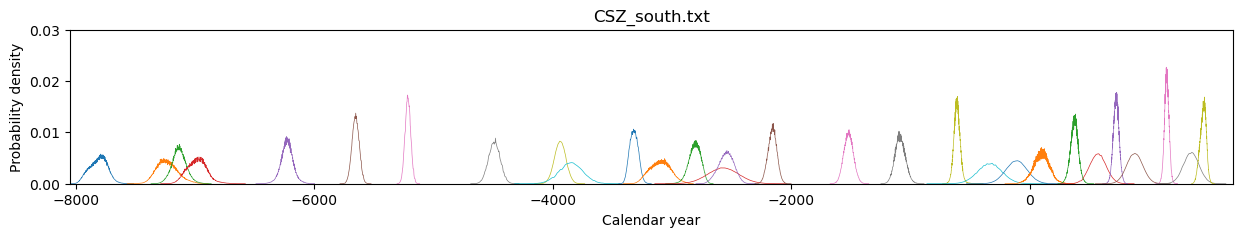

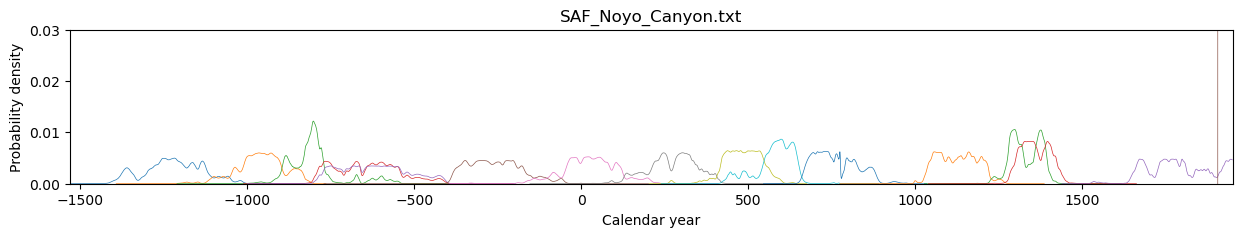

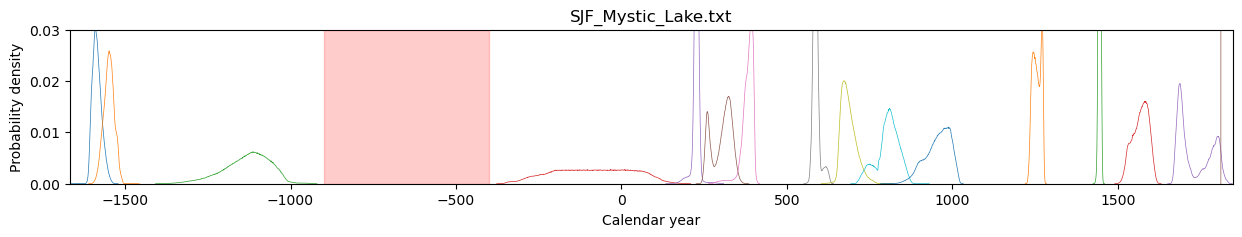

In [16]:
data_files = [
    f for f in os.listdir(data_directory / "trench_records") if f.endswith(".txt")
]
with open(data_directory / "metadata.yaml", "r") as f:
    meta_data = yaml.safe_load(f)

# read in the files
for file in data_files:
    trench_catalog = PaleoseismicCatalog(
        file=data_directory / "trench_records" / file,
        **meta_data[file],
    )

    ax = trench_catalog.plot_pdfs()
    ax.set_title(file)

# get the average interval

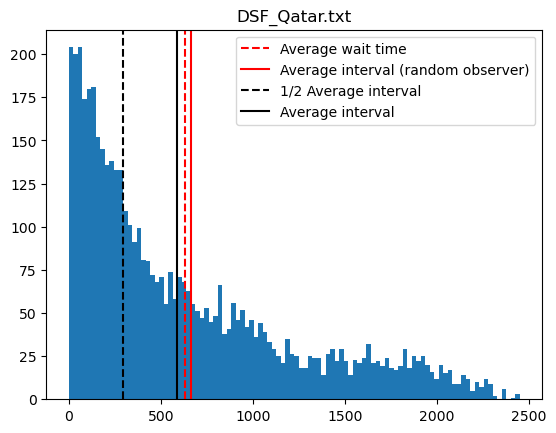

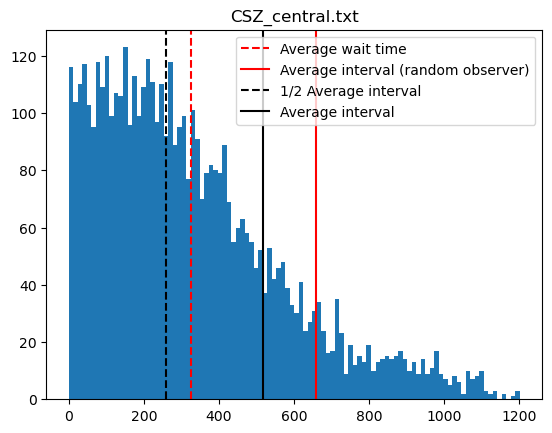

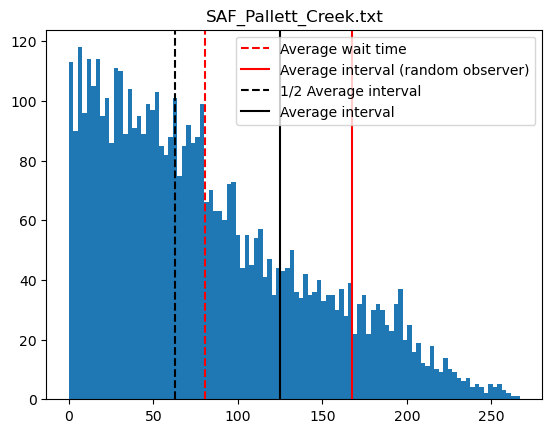

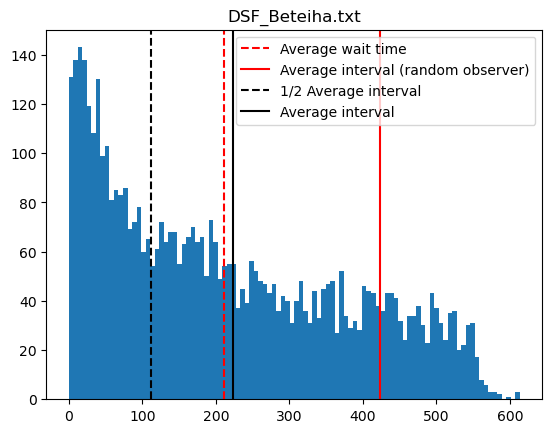

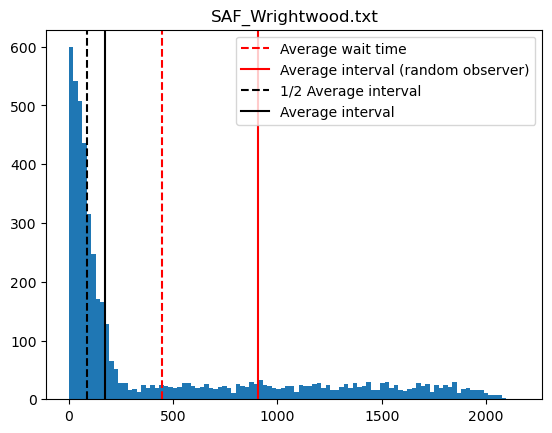

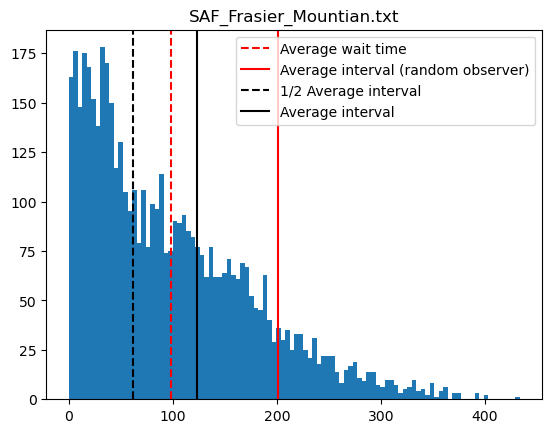

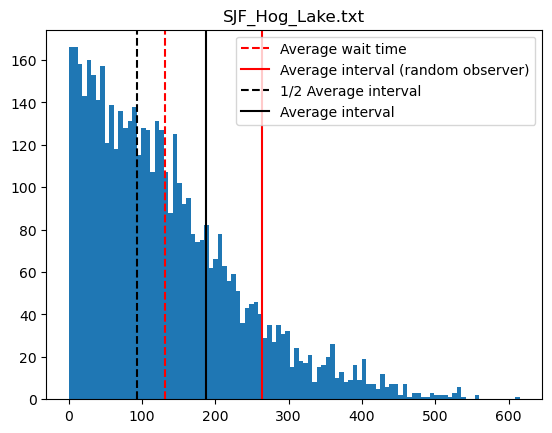

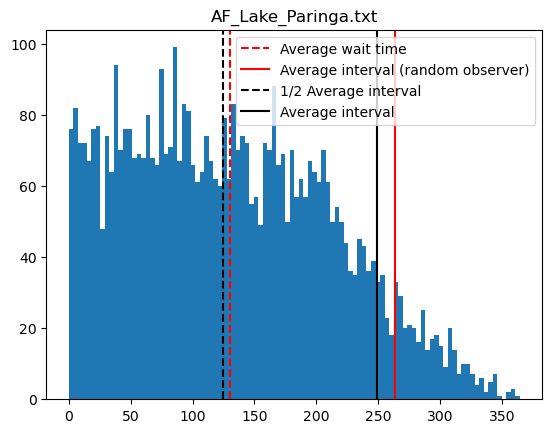

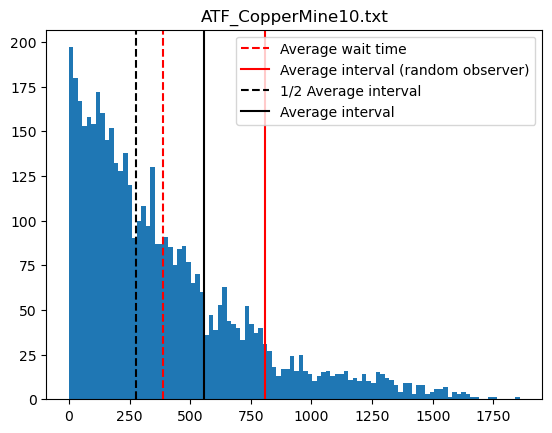

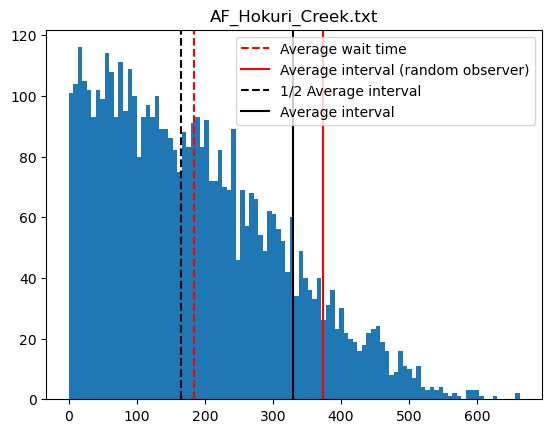

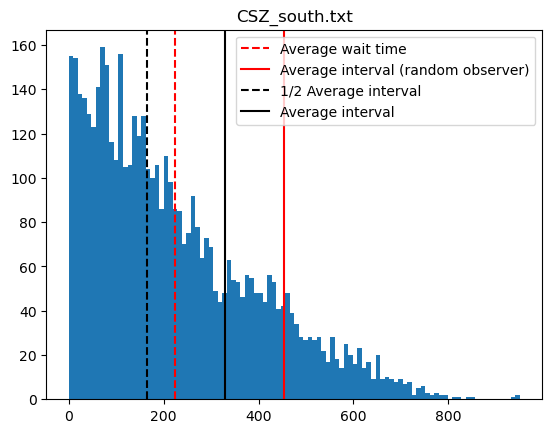

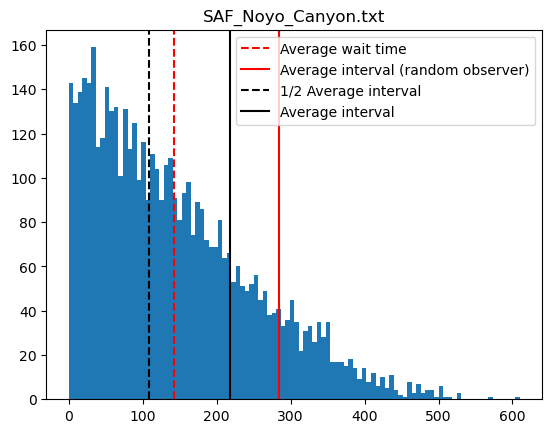

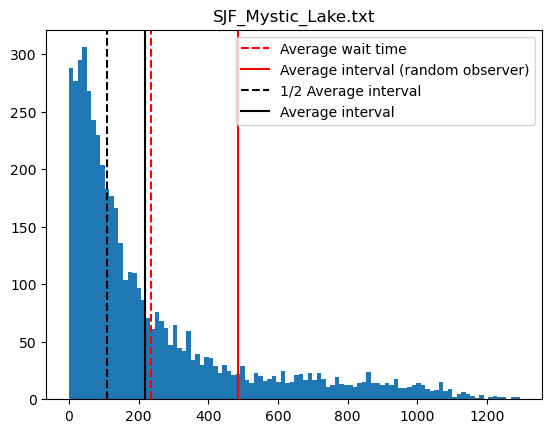

In [ ]:
expected_waiting_time = []
expected_lapse_time = []
average_interval = []


for file in data_files:
    trench_catalog = PaleoseismicCatalog(f'data/{file}')
    ax, waiting_time, lapse_time = trench_catalog.visualize_waiting_time(number_of_samples=5000)
    ax.set_title(file)
    expected_waiting_time.append(np.nanmean(waiting_time))
    expected_lapse_time.append(np.nanmean(lapse_time))
    average_interval.append(trench_catalog.average_interval)


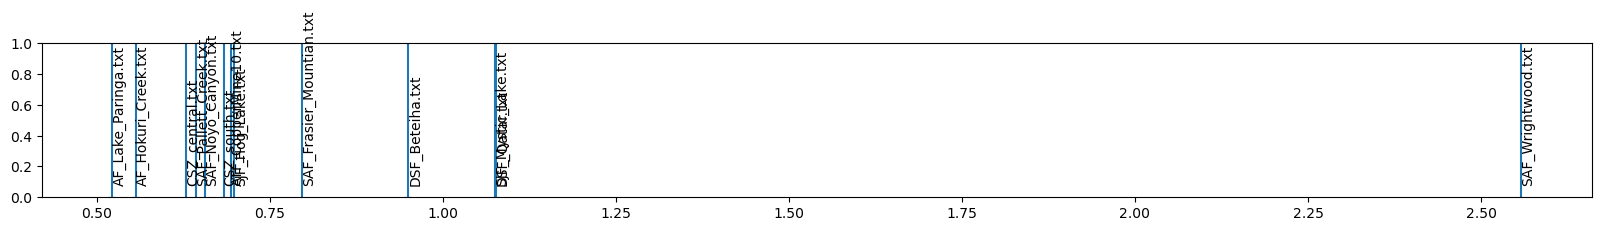

In [ ]:
fig, ax = plt.subplots(figsize=(20,2))
for dt, T, fn in zip(expected_waiting_time, average_interval, data_files):
    ax.axvline(dt/T)
    ax.text(dt/T, 0.1, fn, rotation=90)